# Combining OGGM's climate data with ODINN's MB model

In [1]:
## Environment and packages
using Pkg; Pkg.activate("../../."); Pkg.instantiate()

  Activating environment at `~/Desktop/Jordi/Julia/odinn_toy_model/Project.toml`


In [2]:
ENV["PYTHON"] = "/Users/Bolib001/miniconda3/envs/oggm_env/bin/python3.9" # Choose own Python environment with OGGM's installation
using PyCall
Pkg.build("PyCall")

    Building Conda ─→ `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/299304989a5e6473d985212c28928899c74e9421/build.log`
    Building PyCall → `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/169bb8ea6b1b143c5cf57df6d34d022a7b60c6db/build.log`


## Import Python OGGM libraries and configure Glacier directories

A call to [cfg.initialize()](https://docs.oggm.org/en/stable/generated/oggm.cfg.initialize.html) will read the default parameter file (or any user-provided file) and make them available to all other OGGM tools via the `cfg.PARAMS` dictionary. Here are some examples of these parameters:

In this notebook we'll constantly switch between Julia and Python. The strategy so far is to do as much as possible in Julia (like storing the results and the main variables). However, there are some functions from `xarray` and `pandas` that can get messy when called from Julia, so for those cases they will be called from Python using py" code here". 

In [3]:
# Import in Julia
cfg = pyimport("oggm.cfg")
utils = pyimport("oggm.utils")
workflow = pyimport("oggm.workflow")

cfg.initialize()

2021-10-07 16:23:10: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2021-10-07 16:23:10: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2021-10-07 16:23:10: oggm.cfg: Multiprocessing: using all available processors (N=8)


### Whenever we want to modify a field from a class we need to create a Julian instance:

In [4]:
PARAMS = PyDict(cfg."PARAMS")

PyDict{PyAny, PyAny, true} with 107 entries:
  "has_internet"            => true
  "dl_cache_readonly"       => false
  "use_multiprocessing"     => false
  "use_mp_spawn"            => false
  "mp_processes"            => 8
  "lru_maxsize"             => 100
  "continue_on_error"       => false
  "grid_dx_method"          => "square"
  "topo_interp"             => "cubic"
  "use_intersects"          => true
  "use_compression"         => true
  "border"                  => 40
  "mpi_recv_buf_size"       => 131072
  "use_multiple_flowlines"  => true
  "filter_min_slope"        => true
  "auto_skip_task"          => false
  "correct_for_neg_flux"    => true
  "filter_for_neg_flux"     => false
  "run_mb_calibration"      => false
  "rgi_version"             => "62"
  "use_rgi_area"            => true
  "compress_climate_netcdf" => true
  "use_tar_shapefiles"      => true
  "clip_mu_star"            => false
  "clip_tidewater_border"   => true
  ⋮                         => ⋮

In [5]:
PARAMS["prcp_scaling_factor"], PARAMS["ice_density"], PARAMS["continue_on_error"]
PARAMS["use_multiprocessing"] = true # Let's use multiprocessing

2021-10-07 16:23:13: oggm.cfg: Multiprocessing switched ON after user settings.


true

Each OGGM run needs a **single folder** where to store the results of the computations for all glaciers. This is called a "working directory" and needs to be specified before each run.

In [6]:
PATHS = PyDict(cfg."PATHS")

PyDict{PyAny, PyAny, true} with 7 entries:
  "dl_cache_dir" => "/Users/Bolib001/OGGM/download_cache"
  "tmp_dir"      => "/Users/Bolib001/OGGM/tmp"
  "rgi_dir"      => "/Users/Bolib001/OGGM/rgi"
  "test_dir"     => "/Users/Bolib001/OGGM/tests"
  "working_dir"  => ""
  "dem_file"     => ""
  "climate_file" => ""

In [7]:
PATHS["working_dir"] = "/Users/Bolib001/Jordi/Python/OGGM_data"

"/Users/Bolib001/Jordi/Python/OGGM_data"

**This working directory is meant to be persistent**, i.e. you can stop your processing workflow after any task, and restart from an existing working directory at a later stage.

### Define the glaciers for the run 

In [8]:
rgi_ids = ["RGI60-11.01450"]

1-element Vector{String}:
 "RGI60-11.01450"

### Glacier directories 

The OGGM workflow is organized as a list of **tasks** that have to be applied to a list of glaciers. The vast majority of tasks are called **entity tasks**: they are standalone operations to be realized on one single glacier entity. These tasks are executed sequentially (one after another): they often need input generated by the previous task(s): for example, the climate calibration needs the glacier flowlines, which can be only computed after the topography data has been processed, and so on.

To handle this situation, OGGM uses a workflow based on data persistence on disk: instead of passing data as python variables from one task to another, each task will read the data from disk and then write the computation results back to the disk, making these new data available for the next task in the queue.

These glacier specific data are located in [glacier directories](https://docs.oggm.org/en/stable/glacierdir.html#glacier-directories). In the model, these directories are initialized with the following command (this can take a little while on the first call, as OGGM needs to download some data):

In [9]:
# use elevation band  flowlines
base_url = ("https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/L1-L2_files/elev_bands")

# Where to fetch the pre-processed directories
gdirs = workflow.init_glacier_directories(rgi_ids, from_prepro_level=2,
                                          prepro_border=10,
                                          prepro_base_url=base_url,
                                          prepro_rgi_version="62")
# gdirs = workflow.init_glacier_directories(rgi_ids, from_prepro_level=3, prepro_border=80)
gdir = gdirs[1]
println("Path to the DEM:", gdir.get_filepath("dem"))

Path to the DEM:/Users/Bolib001/Jordi/Python/OGGM_data/per_glacier/RGI60-11/RGI60-11.01/RGI60-11.01450/dem.tif


2021-10-07 16:23:15: oggm.workflow: init_glacier_directories from prepro level 2 on 1 glaciers.
2021-10-07 16:23:15: oggm.workflow: Execute entity task gdir_from_prepro on 1 glaciers
2021-10-07 16:23:15: oggm.utils: /Users/Bolib001/OGGM/download_cache/cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/L1-L2_files/elev_bands/RGI62/b_010/L2/RGI60-11/RGI60-11.01.tar verified successfully.


In [10]:
using PyPlot
graphics = pyimport("oggm.graphics")

PyObject <module 'oggm.graphics' from '/Users/Bolib001/Python/oggm/oggm/graphics.py'>

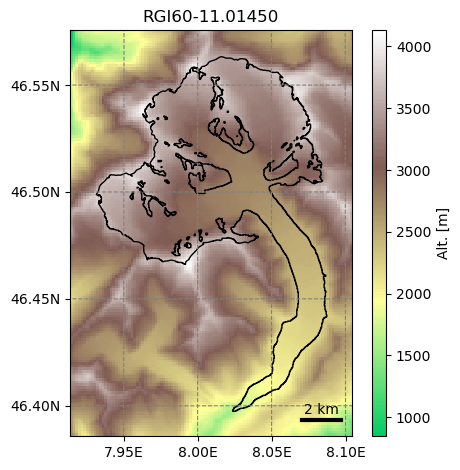

In [11]:
graphics.plot_domain(gdirs)

Another advantage of glacier directories is their persistence on disk: once created, **they can be recovered from the same location** by using `init_glacier_directories` again, but without keyword arguments:

In [12]:
# Fetch the LOCAL pre-processed directories - note that no arguments are used!
# gdirs = workflow.init_glacier_directories(rgi_ids)

## Train simple temperature-index MB model from ODINN using OGGM glacier directories

We import the simple ODINN MB model

### Climate tasks 

The glacier directories we downloaded already contains the climate timeseries for each glacier (`from_prepro_level=3`). Let's have a look at them:

In [13]:
using Dates # to provide correct Julian time slices 

xr = pyimport("xarray")
np = pyimport("numpy")

PyObject <module 'numpy' from '/Users/Bolib001/miniconda3/envs/oggm_env/lib/python3.9/site-packages/numpy/__init__.py'>

In [14]:
# fpath = gdir.get_filepath("climate_historical")
# ds = xr.open_dataset(fpath)

# # Functions to get slices of PyObjects
# slice_idx(idx) = pycall(pybuiltin("slice"), PyObject, idx[1],idx[2])
# sl(pyo,idx) = get(pyo, slice_idx(idx))

# # Data is in hydrological years
# # -> let's just ignore the first and last calendar years
# # sl(ds.temp.resample(time="AS").mean(), (1,-1)).plot() # Keeping the DataArray object (with Pythonic indexes)
# plot(ds.temp.resample(time="AS").mean().to_numpy()[2:end-1]) # Converting to numpy and plotting afterwards (with Julian indexes)


This climate data is called the "baseline climate" for this glacier. It will be used for the mass-balance model calibration, and at the end of this tutorial also to generate the random climate to drive a simulation. When running OGGM with GCM data, the GCM timeseries will be computed as anomalies to this baseline timeseries, hence the name.

Here we are using CRU, but OGGM-Shop also allows to use ERA5 and CERA as baseline.

In [15]:
gdir = gdirs[1]

PyObject <oggm.GlacierDirectory>
  RGI id: RGI60-11.01450
  Region: 11: Central Europe
  Subregion: 11-01: Alps                            
  Glacier type: Glacier
  Terminus type: Land-terminating
  Status: Glacier or ice cap
  Area: 82.206 km2
  Lon, Lat: (8.01919, 46.5028)
  Grid (nx, ny): (107, 154)
  Grid (dx, dy): (137.0, -137.0)


We extract the climate data for the period with MB observations. The raw OGGM climate data has a monthly resolution.

We use the W5E5 climate with daily temperature and precipitation and a changing lapse rate (data from ERA5)

In [16]:
MBsandbox = pyimport("MBsandbox.mbmod_daily_oneflowline")

PARAMS["hydro_month_nh"]=1
climate="W5E5"
MBsandbox.process_w5e5_data(gdir, climate_type=climate, temporal_resol="daily") 
# could use here instead as well:
# MBsandbox.process_era5_daily_data(gdir)

2021-10-07 16:23:24: oggm.cfg: PARAMS['hydro_month_nh'] changed from `10` to `1`.
2021-10-07 16:23:24: MBsandbox.mbmod_daily_oneflowline: (RGI60-11.01450) process_w5e5_data
2021-10-07 16:23:24: oggm.utils: No known hash for cluster.klima.uni-bremen.de/~lschuster/w5e5v2.0/flattened/daily/w5e5v2.0_tas_global_daily_flat_glaciers_1979_2019.nc
2021-10-07 16:23:24: oggm.utils: No known hash for cluster.klima.uni-bremen.de/~lschuster/w5e5v2.0/flattened/daily/w5e5v2.0_pr_global_daily_flat_glaciers_1979_2019.nc
2021-10-07 16:23:24: oggm.utils: No known hash for cluster.klima.uni-bremen.de/~lschuster/w5e5v2.0/flattened/daily/w5e5v2.0_glacier_invariant_flat.nc
2021-10-07 16:23:28: oggm.utils: /Users/Bolib001/OGGM/download_cache/cluster.klima.uni-bremen.de/~oggm/climate/era5/monthly/vdr/ERA5_lapserates_monthly.nc verified successfully.


In [17]:
fpath = gdir.get_filepath("climate_historical", filesuffix="_daily_W5E5")
climate = xr.open_dataset(fpath)

PyObject <xarray.Dataset>
Dimensions:   (time: 14975)
Coordinates:
  * time      (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-12-31
Data variables:
    prcp      (time) float32 ...
    temp      (time) float32 ...
    gradient  (time) float32 ...
Attributes:
    ref_hgt:         1764.0
    ref_pix_lon:     8.25
    ref_pix_lat:     46.75
    ref_pix_dis:     32652.873631988525
    climate_source:  temp: W5E5_daily, prcp: W5E5_daily, lapse rate: ERA5dr
    hydro_yr_0:      1979
    hydro_yr_1:      2019
    author:          OGGM
    author_info:     Open Global Glacier Model

In [18]:
pd = pyimport("pandas")

# get the geodetic data for calibration
url = "https://cluster.klima.uni-bremen.de/~oggm/geodetic_ref_mb/hugonnet_2021_ds_rgi60_pergla_rates_10_20_worldwide.csv"
path = utils.file_downloader(url)
pd_geodetic = pd.read_csv(path, index_col="rgiid")

pd_geodetic = get(pd_geodetic.loc, pd_geodetic.period == "2000-01-01_2020-01-01")
mb_geodetic = get(pd_geodetic.loc, rgi_ids).dmdtda.values * 1000

years = range(2000, 2020, step=1)

2021-10-07 16:23:29: oggm.utils: /Users/Bolib001/OGGM/download_cache/cluster.klima.uni-bremen.de/~oggm/geodetic_ref_mb/hugonnet_2021_ds_rgi60_pergla_rates_10_20_worldwide.csv verified successfully.


2000:1:2020

In [19]:
mb_type = "mb_real_daily"
grad_type = "var_an_cycle" # could use here as well 'cte'
# mb_mod = MBsandbox.TIModel(gdir, nothing, mb_type=mb_type, grad_type=grad_type, baseline_climate=climate, residual=0)
# fs = "_daily_".*climate
fs = "_daily_W5E5"

"_daily_W5E5"

In [20]:
mb_glaciological = gdir.get_ref_mb_data(input_filesuffix=fs)

,WGMS_ID,POLITICAL_UNIT,NAME,AREA,WINTER_BALANCE,SUMMER_BALANCE,ANNUAL_BALANCE,REMARKS,RGI_ID
YEAR,,,,,,,,,
1979,360,CH,GROSSER ALETSCH,86.3800,1007.0,-1515.0,-508.0,Bs calculated from reported Bw and Ba.,RGI50-11.01450
1980,360,CH,GROSSER ALETSCH,86.5550,1340.0,-716.0,624.0,Bs calculated from reported Bw and Ba.,RGI50-11.01450
1981,360,CH,GROSSER ALETSCH,84.2800,1004.0,-1027.0,-23.0,Bs calculated from reported Bw and Ba.,RGI50-11.01450
1982,360,CH,GROSSER ALETSCH,83.8325,890.0,-1252.0,-362.0,Bs calculated from reported Bw and Ba.,RGI50-11.01450
1983,360,CH,GROSSER ALETSCH,83.7850,1269.0,-1586.0,-317.0,Bs calculated from reported Bw and Ba.,RGI50-11.01450
1984,360,CH,GROSSER ALETSCH,83.7425,989.0,-809.0,180.0,Bs calculated from reported Bw and Ba.,RGI50-11.01450
1985,360,CH,GROSSER ALETSCH,83.6925,861.0,-1179.0,-318.0,Bs calculated from reported Bw and Ba.,RGI50-11.01450
1986,360,CH,GROSSER ALETSCH,83.6725,950.0,-1764.0,-814.0,Bs calculated from reported Bw and Ba.,RGI50-11.01450
1987,360,CH,GROSSER ALETSCH,83.6200,1263.0,-1457.0,-194.0,Bs calculated from reported Bw and Ba.,RGI50-11.01450


In [21]:
climate_ref = climate.sel(time=DateTime(mb_glaciological.index[1],1,1):Month(1):DateTime(mb_glaciological.index[end],1,1));

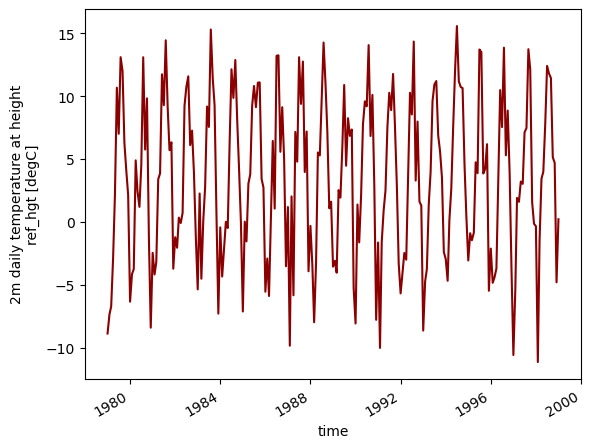

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fdfc29a61c0>

In [22]:
climate_ref.temp.plot(c="darkred")

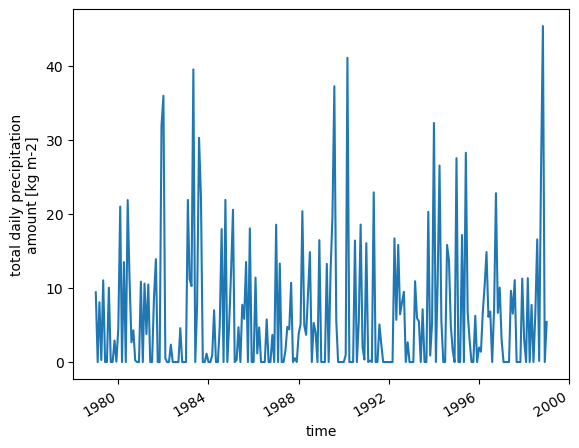

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fdfc1fcddc0>

In [23]:
climate_ref.prcp.plot()

## Mass balance UDE model

We build a UDE MB model, using the OGGM glacier directory data for training.

In [24]:
using Base: @kwdef
@kwdef mutable struct Hyperparameters
    batchsize::Int = 500    # batch size
    η::Float64 = 0.1   # learning rate
    epochs::Int = 500        # number of epochs
    use_cuda::Bool = true   # use gpu (if cuda available)
end

Hyperparameters

In [25]:
using Flux

hyparams = Hyperparameters()

# Leaky ReLu as activation function
leakyrelu(x, a=0.01) = max(a*x, x)
relu_acc(x) = min(max(1, x), 2)
relu_abl(x) = min(max(3, x), 12)

# Define the networks 1->5->5->5->1
global Up = Chain(
    Dense(1,10,initb = Flux.glorot_normal), 
    BatchNorm(10, leakyrelu),
    Dense(10,10,initb = Flux.glorot_normal), 
    BatchNorm(10, leakyrelu),
    Dense(10,5,initb = Flux.glorot_normal), 
    BatchNorm(5, leakyrelu),
    Dense(5,1, relu_acc, initb = Flux.glorot_normal)
)

global Ut = Chain(
    Dense(1,10,initb = Flux.glorot_normal), 
    BatchNorm(10, leakyrelu),
    Dense(10,10,initb = Flux.glorot_normal), 
    BatchNorm(10, leakyrelu),
    Dense(10,5,initb = Flux.glorot_normal), 
    BatchNorm(5, leakyrelu),
    Dense(5,1, relu_abl, initb = Flux.glorot_normal)
)

Chain(
  Dense(1, 10),                         # 20 parameters
  BatchNorm(10, leakyrelu),             # 20 parameters, plus 20
  Dense(10, 10),                        # 110 parameters
  BatchNorm(10, leakyrelu),             # 20 parameters, plus 20
  Dense(10, 5),                         # 55 parameters
  BatchNorm(5, leakyrelu),              # 10 parameters, plus 10
  Dense(5, 1, relu_abl),                # 6 parameters
)         # Total: 14 trainable arrays, 241 parameters,
          # plus 6 non-trainable, 50 parameters, summarysize 2.316 KiB.

In [26]:
# Temperature-index equation for point glacier mass balance
function MB(P, T, Up, Ut)
    T_melt = 0
    MB = P.*Up - max.(T.-T_melt, 0).*Ut
    return MB
end

MB (generic function with 1 method)

In [27]:
# We determine the loss function
function loss(batch)
    l, l_acc, l_abl = 0.0f0, 0.0f0, 0.0f0
    num = 0
    for (x, y) in batch

        # Make NN predictions
        p_batch = x[1,:]'
        t_batch = x[2,:]'
        pdd_batch = max.(t_batch.-0, 0)
        Ŷp = Up(p_batch)
        Ŷt = Ut(pdd_batch)
        
        # We evaluate the MB as the combination of Accumulation - Ablation         
        w_pc=1000
        l_MB = sqrt(Flux.Losses.mse(MB(p_batch, t_batch, Up, Ut), y; agg=mean))
        l_range_acc = sum((max.((Ŷp/p_batch).-110, 0)).*w_pc)
        l_range_abl = sum((max.((Ŷt/pdd_batch).-110, 0)).*w_pc)

        #l += l_MB 
        l += l_MB + l_range_acc + l_range_abl
        l_acc += l_range_acc
        l_abl += l_range_abl
        num +=  size(x, 2)

        # println("Accumulation loss: ", l_range_acc)
        # println("Ablation loss: ", l_range_abl)

    end

    return l/num
end

loss (generic function with 1 method)

### WGMS mass balance data

We prepare the dataset with predictors and targets to train the MB model.

In [28]:
annual_MB = mb_glaciological["ANNUAL_BALANCE"];
winter_MB = mb_glaciological["WINTER_BALANCE"];
summer_MB = mb_glaciological["SUMMER_BALANCE"];

### Seasonal climate data to match MB observations

TODO: improve separation of rain/snow.

In [29]:
# Function to convert the baseline OGGM climate dataset to 2D
function create_2D_climate_data(climate, g_dem)
    # Create dummy 2D arrays to have a base to apply gradients afterwards
    temp_2D = climate.temp.data .* ones(size(permutedims(g_dem.data, (1,2,3))))
    snow_2D = climate.prcp.data .* ones(size(permutedims(g_dem.data, (1,2,3))))
    rain_2D = climate.prcp.data .* ones(size(permutedims(g_dem.data, (1,2,3))))

    # We generate a new dataset with the scaled data
    climate_2D = xr.Dataset(
        data_vars=Dict([
            ("temp", (["time","y","x"], temp_2D)),
            ("snow", (["time","y","x"], snow_2D)),
            ("rain", (["time","y","x"], rain_2D)),
            ("gradient", (["time"], climate.gradient.data))
            ]),
        coords=Dict([
            ("time", climate.time),
            ("x", g_dem.x),
            ("y", g_dem.y)
        ]),
        attrs=climate.attrs
    )

    return climate_2D

end

create_2D_climate_data (generic function with 1 method)

We get the glacier's DEM to compute the temperature lapse rate.

In [30]:
g_dem = xr.open_rasterio(gdir.get_filepath("dem"))

PyObject <xarray.DataArray (band: 1, y: 154, x: 107)>
array([[[ 846, 1146, ..., 2498, 2588],
        [ 854, 1126, ..., 2488, 2575],
        ...,
        [2641, 2530, ..., 1378, 1348],
        [2710, 2601, ..., 1340, 1306]]], dtype=int16)
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 5.158e+06 5.158e+06 5.158e+06 ... 5.137e+06 5.137e+06
  * x        (x) float64 -8.041e+03 -7.904e+03 ... 6.344e+03 6.481e+03
Attributes:
    transform:      (137.0, 0.0, -8109.435911986846, 0.0, -137.0, 5158006.537...
    crs:            +init=epsg:32632
    res:            (137.0, 137.0)
    is_tiled:       0
    nodatavals:     (-32768.0,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area

We convert the baseline climate dataset to 2D

In [31]:
climate_2D_ref = create_2D_climate_data(climate_ref, g_dem)

PyObject <xarray.Dataset>
Dimensions:   (time: 241, y: 154, x: 107)
Coordinates:
  * time      (time) datetime64[ns] 1979-01-01 1979-02-01 ... 1999-01-01
  * x         (x) float64 -8.041e+03 -7.904e+03 ... 6.344e+03 6.481e+03
  * y         (y) float64 5.158e+06 5.158e+06 5.158e+06 ... 5.137e+06 5.137e+06
Data variables:
    snow      (time, y, x) float64 9.432 9.432 9.432 9.432 ... 5.42 5.42 5.42
    rain      (time, y, x) float64 9.432 9.432 9.432 9.432 ... 5.42 5.42 5.42
    temp      (time, y, x) float64 -8.856 -8.856 -8.856 ... 0.2282 0.2282 0.2282
    gradient  (time) float32 -0.005391 -0.005693 ... -0.005349 -0.005599
Attributes:
    ref_pix_lon:     8.25
    author:          OGGM
    ref_pix_dis:     32652.873631988525
    hydro_yr_0:      1979
    ref_hgt:         1764.0
    hydro_yr_1:      2019
    ref_pix_lat:     46.75
    climate_source:  temp: W5E5_daily, prcp: W5E5_daily, lapse rate: ERA5dr
    author_info:     Open Global Glacier Model

We apply the temperature lapse rate to the glacier's DEM. This gives as a higher-dimensional xarray `Dataset`, since now for each time step we have a 2D matrix instead of a scalar value.

Bear in mind that this will have to be applied at each time step as the glacier geometry evolves. 

In [156]:
@assert any((climate_2D_ref.time[1].dt.date.data[1] < t_scaled[1]) & any(climate_2D_ref.time[end].dt.date.data[1] > t_scaled[end]))

In [161]:
# Function to apply temperature lapse rates to the full matrix of a glacier
function apply_t_grad(i_climate, g_dem, period, gradient_bounds=[-0.009, -0.003], default_grad=-0.0065)
    @assert any((i_climate.time[1].dt.date.data[1] < period[1]) & any(i_climate.time[end].dt.date.data[1] > period[end])) "Years not found in reference dataset!" 
    climate_scaled = i_climate.sel(time=period[1]:Month(1):period[end]) # Crop desired time period
    gradients = utils.clip_array(climate_scaled.gradient, gradient_bounds[1], gradient_bounds[2]) # Clip gradients within plausible values

    # We apply the gradients to the temperature
    climate_scaled.temp.data = climate_scaled.temp.data .+ gradients.data .* (g_dem.data .- climate_scaled.ref_hgt)
    # We adjust the rain/snow fractions with the updated temperature
    climate_scaled.snow.data = climate_scaled.snow.where(climate_scaled.temp < 0, 0).data
    climate_scaled.rain.data = climate_scaled.rain.where(climate_scaled.temp > 0, 0).data

    return climate_scaled

end

apply_t_grad (generic function with 3 methods)

In [162]:
t_scaled = Date(1989):Month(1):Date(1991) # choose time period 
climate_scaled_ref = apply_t_grad(climate_2D_ref, g_dem, t_scaled)

PyObject <xarray.Dataset>
Dimensions:   (time: 25, y: 154, x: 107)
Coordinates:
  * time      (time) datetime64[ns] 1989-01-01 1989-02-01 ... 1991-01-01
  * x         (x) float64 -8.041e+03 -7.904e+03 ... 6.344e+03 6.481e+03
  * y         (y) float64 5.158e+06 5.158e+06 5.158e+06 ... 5.137e+06 5.137e+06
Data variables:
    snow      (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    rain      (time, y, x) float64 0.0 0.0 0.0 0.0 ... 16.07 16.07 16.07 16.07
    temp      (time, y, x) float64 1.983 0.1775 -1.797 ... 0.6201 0.8031 0.9977
    gradient  (time) float32 -0.006019 -0.005894 ... -0.005303 -0.005721
Attributes:
    ref_pix_lon:     8.25
    author:          OGGM
    ref_pix_dis:     32652.873631988525
    hydro_yr_0:      1979
    ref_hgt:         1764.0
    hydro_yr_1:      2019
    ref_pix_lat:     46.75
    climate_source:  temp: W5E5_daily, prcp: W5E5_daily, lapse rate: ERA5dr
    author_info:     Open Global Glacier Model

We display the downscaled temperatures to make sure everything is fine.

In [34]:
# Use ProPlot for serious scientific plots with lots of subplots
pplt = pyimport("proplot")

PyObject <module 'proplot' from '/Users/Bolib001/miniconda3/envs/oggm_env/lib/python3.9/site-packages/proplot/__init__.py'>

In [176]:
climate_scaled_ref.where(climate_scaled_ref.time.dt.year == 1989)

PyObject <xarray.Dataset>
Dimensions:   (time: 25, y: 154, x: 107)
Coordinates:
  * time      (time) datetime64[ns] 1989-01-01 1989-02-01 ... 1991-01-01
  * x         (x) float64 -8.041e+03 -7.904e+03 ... 6.344e+03 6.481e+03
  * y         (y) float64 5.158e+06 5.158e+06 5.158e+06 ... 5.137e+06 5.137e+06
Data variables:
    snow      (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
    rain      (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
    temp      (time, y, x) float64 1.983 0.1775 -1.797 -2.778 ... nan nan nan
    gradient  (time) float32 -0.006019 -0.005894 -0.005869 ... nan nan nan
Attributes:
    ref_pix_lon:     8.25
    author:          OGGM
    ref_pix_dis:     32652.873631988525
    hydro_yr_0:      1979
    ref_hgt:         1764.0
    hydro_yr_1:      2019
    ref_pix_lat:     46.75
    climate_source:  temp: W5E5_daily, prcp: W5E5_daily, lapse rate: ERA5dr
    author_info:     Open Global Glacier Model

In [167]:
# TODO: correctly retrieve the glacier coordinates to plot them in `imshow` as an extent
function plot_monthly_temps_map(climate, year)
    climate = climate.where(climate.time.dt.year == year, drop=true)
    fig_clim, ax_clim = pplt.subplots([1:6, 7:12], axheight=2)
    fig_clim.format(
        abc=true, abcloc="ul", suptitle= ("$year - monthly temperature")
    )
    for mon in 1:12
        # m_temp = climate.temp[mon].plot(ax=ax_clim[mon])
        m_temp = ax_clim[mon].imshow(climate.temp[mon], cmap="Thermal", 
                vmin=minimum(climate.temp.data), vmax=maximum(climate.temp.data)) # set common min max temp
        ax_clim[mon].set_title(Dates.monthname(mon))
        if(mon == 12)
            fig_clim.colorbar(m_temp, label="Air temperature (2m)")
        end
    end
end

plot_monthly_temps_map (generic function with 1 method)

In [168]:
plot_monthly_temps_map(climate_scaled_ref, 1989)

LoadError: PyError ($(Expr(:escape, :(ccall(#= /Users/Bolib001/.julia/packages/PyCall/BD546/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'TypeError'>
TypeError("cond argument is array([ True,  True,  True,  True,  True,  True,  True,  True,  True,\n        True,  True,  True, False, False, False, False, False, False,\n       False, False, False, False, False, False, False]) but must be a <class 'xarray.core.dataset.Dataset'> or <class 'xarray.core.dataarray.DataArray'>")
  File "/Users/Bolib001/miniconda3/envs/oggm_env/lib/python3.9/site-packages/xarray/core/common.py", line 1266, in where
    raise TypeError(


We classify the climate dataset into ablation and accumulation seasons

In [318]:
function is_abl(month)
    return (month >= 4) & (month <= 10)
end

function is_acc(month)
    return (month <= 4) & (month >= 10)
end

is_acc (generic function with 1 method)

In [319]:
climate_abl_ref = climate_scaled_ref.sel(time=is_abl(climate_scaled_ref.time.dt.month))
climate_acc_ref = climate_scaled_ref.sel(time=is_acc(climate_scaled_ref.time.dt.month))

PyObject <xarray.Dataset>
Dimensions:   (time: 0, y: 154, x: 107)
Coordinates:
  * time      (time) datetime64[ns] 
  * x         (x) float64 -8.041e+03 -7.904e+03 ... 6.344e+03 6.481e+03
  * y         (y) float64 5.158e+06 5.158e+06 5.158e+06 ... 5.137e+06 5.137e+06
Data variables:
    snow      (time, y, x) float64 
    rain      (time, y, x) float64 
    temp      (time, y, x) float64 
    gradient  (time) float32 
Attributes:
    ref_pix_lon:     8.25
    author:          OGGM
    ref_pix_dis:     32652.873631988525
    hydro_yr_0:      1979
    ref_hgt:         1764.0
    hydro_yr_1:      2019
    ref_pix_lat:     46.75
    climate_source:  temp: W5E5_daily, prcp: W5E5_daily, lapse rate: ERA5dr
    author_info:     Open Global Glacier Model

Now we have a climate dataset for a given glacier ready to be used for training. We have 2D grid values for scaled air temperature at each glacier altitude, and the corresponding fractions of snow and rain.

We create a function to compute point glacier mass balance for a given glacier and a given time period.

In [ ]:
function compute_MB(gdir, climate, period)
    apply_t_grad(climate_2D_ref, g_dem, y_scaled)
end

In [ ]:

X = vcat(prcp_ref.data, temp_ref.data)
Y = collect(annual_MB.values)
Yw = collect(winter_MB.values)
Ys = collect(summer_MB.values)

# Very important:
# Shuffle batches and use batchsize similar to dataset size for easy training
data = Flux.Data.DataLoader((X, Y), batchsize=hyparams.batchsize, (X, Y), shuffle=true)